## Import Dependencies

In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

## Now we goinng to import our tensorflow dependencies - Functional API
So the model we are going to build is siamese neural network which allows us to do something we call a one shot image Recognition.We can actually pass through two images and determine whether or not that image is the same.
When you look at the achitecture here(Diagram 3) ,you can see that we are going to have two inputs(images) at the same time and we are going to have this distance layer, so this actually measures the similarities between this two images and we are going to train our neural network to determine what that similarity is like, so if it's very similar then we are going to output a 1 which means it is verified if not 0 which means we are unverified.

(Diagram 4)
Now in terms of the neural network that we are going to be building,we are effectively going to be implementing this(Diagram).We are going to be using the tensorflow functional API.
so we need to import those functional Api components.

Conv2D - Allows us to perform convolutional neural networks
Dense - This gives us a fully connected layer
Maxpooling - So this allows us to pool our layers back together and effectively shrinks the information that we actually got.
Input- defines what we are actually passing through our model 
Flatten -This takes all information taken from a previous layer adn flattens it down to a single dimension.So that allows us to pass convulational neural networks to a dense layer.

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer,Conv2D, Dense, MaxPooling2D, Input, Flatten,Embedding
import tensorflow as tf

## Set GPU Growth
We are limiting how much the RAM Tensorflow can use on the GPU, because by default tensorflow is going to expand to take it all over and if you dont run this then uyou are goingto run into out of memory errors. So This avoids this.

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
#So what this line is doing is its getting allthe available gpus on our machine
gpus = tf.config.experimental.list_physical_devices('GPU')
#Loopinf through gpus to set our memory growth
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## Create Folder Structures
So we actaully setting up our Folder structures to make sure we are in a good place when it comes to getting our datac folders: Anchor, Positive and Negative
Diagram 2
So when we actually move to our neural network to perform our facial verification, we are actally goinhg to pass through two images,we going to pass through an image called Anchor(input image captured from your phone or webcam, an image verifying you in real time) and we then pass through a verification image(Positive or Negative). So what we are effectively going to do is to say hey does our anchor match with our verication image, if it does, outputs same, when our neural netwrok does, it it outputs 1.  Because we want out neural network to be able to distiguish between ouselves and another person.
So we are going to call the input image an Anchor image, the Verifcation image which is positive a positive image and the ver image which is negative a negative image.
Actaully downloaded all the negative images from a repository called "Labelled faces in the world".
we are going to be using our webcam to collect our positives.

In [6]:
# Setup paths
#so what os.path.join does is it joins different directories together to be able to form a full file path
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# Collect Positives and Anchors

## Untar Labelled Faces in the Wild Dataset

In [494]:
# http://vis-www.cs.umass.edu/lfw/

In [495]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
#!tar -xf lfw.tgz
#Already did that


In [ ]:
#Move LFWW Images to the following repository data/negative
for directory in os.listdir("lfw"):
    for file in os.listdir(os.path.join("lfw", directory)):  
        EX_PATH = os.path.join("lfw",directory,file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH,NEW_PATH)


## Collect Positive and Anchor images

In [4]:
# Import uuid library to generate unique image names
import uuid

In [8]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\2f034539-23b8-11ed-b67b-80ce6285d360.jpg'

In [9]:
#For this what we are going to be doing is we are going to be using our openCv to access our webcam tp collect our anchor and positive
# Establish a connection to the webcam
cap = cv2.VideoCapture(0) #Video capture device 0
while cap.isOpened():
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

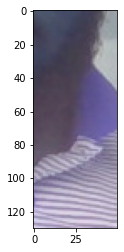

In [10]:
plt.imshow(frame[120:120+250,200:200+250, :])

# Data Augmention

In [502]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

# load and Preprocess Images

## Get Image Directories

so what we ae going to respectively load all the folders from their respective directories, we are goig to create a preprocessing pipeline and associate our positive and negative classes.

In [11]:
#Grabbing all different images within  specific directories
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(3000)

In [12]:
dir_test = anchor.as_numpy_iterator()

In [13]:
print(dir_test.next())

b'data\\anchor\\2875b9d3-23b9-11ed-9e96-80ce6285d360.jpg'


## Preprocessing - Scale and Resize

In [14]:
#Writing a preprocessing function that loads our images from our directories, resize it(100px by 100px) and perform some scaling
#So we are going to convert all our image values from 0 to 255 to 0 to 1 so this help our neural network optimize a little easier

def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [15]:
img = preprocess('data\\anchor\\2875b9d3-23b9-11ed-9e96-80ce6285d360.jpg')

In [16]:
img.numpy().max()

1.0

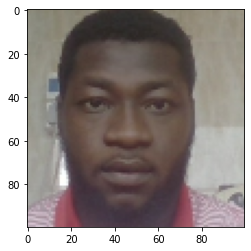

In [17]:
plt.imshow(img)

## Create Labelled Dataset
Creating a set of twins, because we are going to be passing two values at the same time

In [30]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0



In [18]:
# Creating our positive Smaples
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
# Creating our negative Samples
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
#Went ahaid to concatinate these together so that we can be able to work with them
data = positives.concatenate(negatives)

In [19]:
samples = data.as_numpy_iterator()

In [20]:
exampple = samples.next()

In [21]:
exampple

(b'data\\anchor\\15e95f6e-23b9-11ed-8e7a-80ce6285d360.jpg',
 b'data\\positive\\d69dbe0b-23b8-11ed-8896-80ce6285d360.jpg',
 1.0)

## Build and Train Test Partition

In [22]:
#Then we write our preprocess twin function and have to apply this to our data
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [23]:
res = preprocess_twin(*exampple)

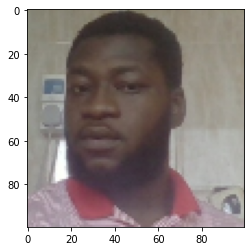

In [24]:
plt.imshow(res[1])

In [25]:
res[2]

1.0

In [26]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [27]:
# Training partition

#This is effectively gabbing a certain percentage of our data set,actually taking 70% as my training partition
train_data = data.take(round(len(data)*.7))

#Now we passing our data into 16 batches of images
train_data = train_data.batch(16)

#Prefech method start preprocessing the next set of images so that we dont bother our neural network when we go and train
train_data = train_data.prefetch(8)

In [28]:
# Testing partition
#Going to grab the last 30 pecent of my images
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# Model Engineering
#Now getting into the deep learning part of the model

1.Build an embedding layer
This is actally going to form a feature mapping mapping pipeline for our specific model.This is going to go into ou embedding layer and  convert our raw image into a data representation.Going to allow our neural network to ddetermine whether the person is verified or not

2.Create an L1 Distance Layer
we compare our Anchor image with our positive image or negative image using our L1 distance layer to check whether or image is verified or not

3.we Compile them together to build our  Siamese 

A Siamese Network is an Artificial Neural network that works on two inputs to compute a comparable output

## Build Embedding Layer

In [29]:
inp = Input(shape=(100,100,3), name='input_image')

In [30]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [31]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [32]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [33]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [34]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [35]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [36]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [37]:

def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [38]:
embedding = make_embedding()

In [39]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

## Build Distance Layer

In [40]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [41]:
l1 = L1Dist()

In [42]:
l1

## Make a Siamese Model

In [43]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [44]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [45]:
siamese_layer = L1Dist()

In [46]:
distances = siamese_layer(inp_embedding, val_embedding)


In [47]:
classifier = Dense(1, activation='sigmoid')(distances)

In [48]:
classifier


<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [49]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [50]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [51]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [52]:
siamese_model = make_siamese_model()

In [53]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# Training

## Setup Loss and Optimizer

In [54]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [55]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## Establish Checkpoints

In [56]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## Build Train Step Function

In [57]:
test_batch = train_data.as_numpy_iterator()

In [58]:
batch_1 = test_batch.next()

In [59]:
X = batch_1[:2]

In [60]:
y = batch_1[2]

In [61]:
y

array([1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.],
      dtype=float32)

In [62]:
tf.losses.BinaryCrossentropy??

In [63]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

## Building Training Loop

In [64]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall


In [65]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## Train Model

In [66]:
EPOCHS = 30

In [67]:
train(train_data, EPOCHS)


 Epoch 1/30
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
5/5 [==============================] - 279s 53s/step
0.33654094 0.0 0.0

 Epoch 2/30
5/5 [==============================] - 265s 50s/step
0.2547598 0.53571427 1.0

 Epoch 3/30
5/5 [==============================] - 301s 57s/step
0.1185652 0.8333333 1.0

 Epoch 4/30
5/5 [==============================] - 304s 60s/step
0.20434113 0.7777778 1.0

 Epoch 5/30
5/5 [==============================] - 282s 53s/step
0.33386865 0.7586207 1.0

 Epoch 6/30
5/5 [==============================] - 250s 47s/step
0.17494497 0.9 1.0

 Epoch 7/30
5/5 [==============================] - 219s 42s/step
0.000121364836 0.88 1.0

 Epoch 8/30
5/5 [==============================] - 219s 42s/step
0.021806562 0.85714287 1.0

 Epoch 9/30
5/5 [==============================] - 218s 42s/step
0.15999846 1.0 1.0

 Epoch 10/30
5/5 [==========================

# Evaluate Model

## Import Metrics

In [68]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## Make Predictions

In [69]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [70]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat

array([[7.01671681e-08],
       [1.19007105e-04],
       [8.47986996e-08],
       [1.01848485e-08],
       [9.55367454e-07],
       [1.64909828e-08],
       [9.95656729e-01],
       [1.41104167e-07],
       [8.42214760e-08],
       [1.80313265e-07],
       [1.07184297e-08],
       [6.79926515e-08],
       [7.01963501e-08],
       [9.98368025e-01],
       [1.10113749e-08],
       [9.95857596e-01]], dtype=float32)

In [71]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1]

In [72]:
y_true

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.],
      dtype=float32)

## Calculate Metrics

In [73]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [74]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()


1.0

In [75]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1.0 1.0


## Visualize Results

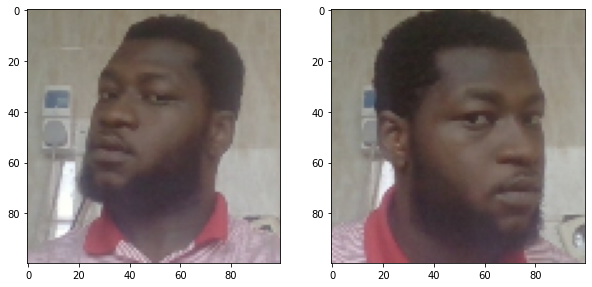

In [78]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

## Save Model

In [79]:
# Save weights
siamese_model.save('siamesemodelv5.h5')

In [80]:
L1Dist

__main__.L1Dist

In [89]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv5.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [90]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

array([[9.96323407e-01],
       [1.04354884e-04],
       [7.66272478e-07],
       [3.26647616e-08],
       [9.97865677e-01],
       [2.61106464e-07],
       [9.88303900e-01],
       [4.21368895e-09],
       [9.94358897e-01],
       [4.93417467e-08],
       [9.98368025e-01],
       [9.99883175e-01],
       [1.64909828e-08],
       [3.18162385e-09]], dtype=float32)

In [91]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# Real Time Test

## Verification Function

In [370]:
application_data\verification_images

In [92]:
os.listdir(os.path.join('application_data', 'verification_images'))


['3dd5f3b0-23b9-11ed-8bf0-80ce6285d360.jpg',
 '3e7a0103-23b9-11ed-b1cb-80ce6285d360.jpg',
 'ab5893c8-23b8-11ed-8734-80ce6285d360.jpg',
 'ab8d3141-23b8-11ed-9932-80ce6285d360.jpg',
 'abcdaad0-23b8-11ed-969b-80ce6285d360.jpg',
 'ae60d415-23b8-11ed-bb12-80ce6285d360.jpg',
 'ae99efa3-23b8-11ed-80bd-80ce6285d360.jpg',
 'afbdf425-23b8-11ed-b57e-80ce6285d360.jpg',
 'ce515c58-23b8-11ed-aaf8-80ce6285d360.jpg',
 'd0b83f0e-23b8-11ed-91d5-80ce6285d360.jpg',
 'd2128666-23b8-11ed-95d9-80ce6285d360.jpg',
 'd2683aab-23b8-11ed-9f16-80ce6285d360.jpg',
 'd46d8a3d-23b8-11ed-8d05-80ce6285d360.jpg',
 'd4d19e1d-23b8-11ed-ba1c-80ce6285d360.jpg',
 'd6404475-23b8-11ed-9e6a-80ce6285d360.jpg',
 'd69dbe0b-23b8-11ed-8896-80ce6285d360.jpg',
 'd702202e-23b8-11ed-b3eb-80ce6285d360.jpg',
 'd8124e90-23b8-11ed-a3ca-80ce6285d360.jpg',
 'da2c3c39-23b8-11ed-9566-80ce6285d360.jpg',
 'da826af4-23b8-11ed-835b-80ce6285d360.jpg',
 'dbfb15cb-23b8-11ed-94c3-80ce6285d360.jpg',
 'dd6590e9-23b8-11ed-b97a-80ce6285d360 - Copy.jpg',
 'd

In [93]:
os.path.join('application_data', 'input_image', 'input_image.jpg')


'application_data\\input_image\\input_image.jpg'

In [94]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\3dd5f3b0-23b9-11ed-8bf0-80ce6285d360.jpg
application_data\verification_images\3e7a0103-23b9-11ed-b1cb-80ce6285d360.jpg
application_data\verification_images\ab5893c8-23b8-11ed-8734-80ce6285d360.jpg
application_data\verification_images\ab8d3141-23b8-11ed-9932-80ce6285d360.jpg
application_data\verification_images\abcdaad0-23b8-11ed-969b-80ce6285d360.jpg
application_data\verification_images\ae60d415-23b8-11ed-bb12-80ce6285d360.jpg
application_data\verification_images\ae99efa3-23b8-11ed-80bd-80ce6285d360.jpg
application_data\verification_images\afbdf425-23b8-11ed-b57e-80ce6285d360.jpg
application_data\verification_images\ce515c58-23b8-11ed-aaf8-80ce6285d360.jpg
application_data\verification_images\d0b83f0e-23b8-11ed-91d5-80ce6285d360.jpg
application_data\verification_images\d2128666-23b8-11ed-95d9-80ce6285d360.jpg
application_data\verification_images\d2683aab-23b8-11ed-9f16-80ce6285d360.jpg
application_data\verification_images\d46d8a3d-23b8-11ed-8d05-80c

In [95]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

# OpenCV Real Time Verification

In [130]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.8, 0.9)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [131]:
results

[array([[0.93829596]], dtype=float32),
 array([[0.572102]], dtype=float32),
 array([[0.98740363]], dtype=float32),
 array([[0.9803661]], dtype=float32),
 array([[0.958526]], dtype=float32),
 array([[0.7954118]], dtype=float32),
 array([[0.81027627]], dtype=float32),
 array([[0.7660966]], dtype=float32),
 array([[0.99994314]], dtype=float32),
 array([[0.99996084]], dtype=float32),
 array([[0.999956]], dtype=float32),
 array([[0.9999478]], dtype=float32),
 array([[0.99993515]], dtype=float32),
 array([[0.99991024]], dtype=float32),
 array([[0.3942916]], dtype=float32),
 array([[0.8545782]], dtype=float32),
 array([[0.995895]], dtype=float32),
 array([[0.9999764]], dtype=float32),
 array([[0.8940236]], dtype=float32),
 array([[0.39514944]], dtype=float32),
 array([[0.9849231]], dtype=float32),
 array([[0.8365103]], dtype=float32),
 array([[0.8365103]], dtype=float32),
 array([[0.54013324]], dtype=float32),
 array([[0.54013324]], dtype=float32),
 array([[0.99612343]], dtype=float32),
 arra